Files loaded successfully!

📊 EEG data shape: (8, 350, 1600) (channels, samples, events)
Sampling rate: 250 Hz
Total trials: 1600 | Targets: 200 | Non-targets: 1400

🔧 Starting Preprocessing...

Preprocessing (Filtering and Baseline Correction) Complete!


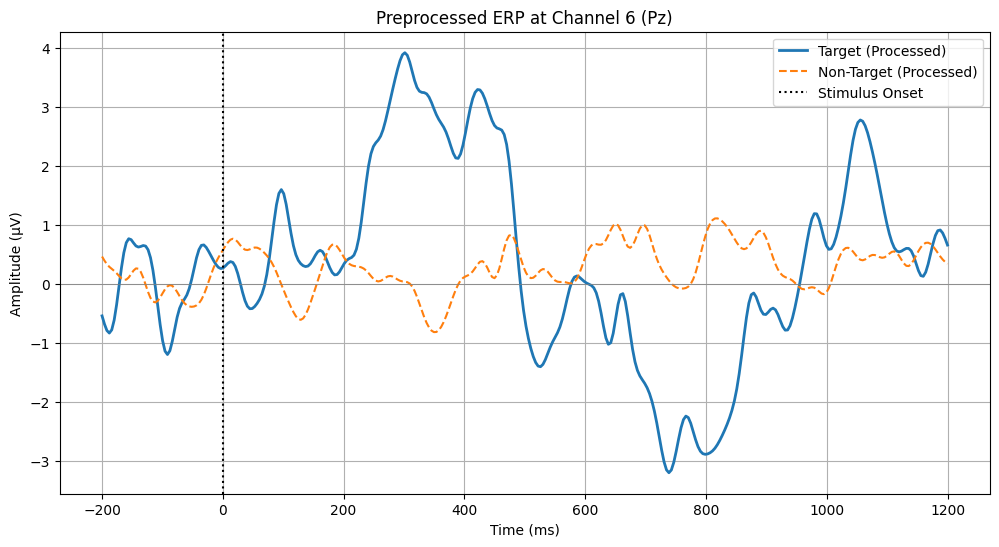

In [8]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, classification_report
)

# --- 1. Define File Paths ---
base_path = '../data/SBJ01/S01/Train/'
mat_file = os.path.join(base_path, 'trainData.mat')
targets_file = os.path.join(base_path, 'trainTargets.txt')

# --- 2. Load the EEG Data and Labels ---
try:
    mat_contents = sio.loadmat(mat_file)
    eeg_data = mat_contents['trainData']
    labels = np.loadtxt(targets_file, dtype=int)
    print("Files loaded successfully!")
except FileNotFoundError as e:
    raise SystemExit(f"❌ Error loading files: {e}")

# --- 3. Verify Data Dimensions ---
if 'eeg_data' in locals():
    num_channels, num_samples, num_events = eeg_data.shape
    sampling_rate = 250
    print(f"\n📊 EEG data shape: {eeg_data.shape} (channels, samples, events)")
    print(f"Sampling rate: {sampling_rate} Hz")
    print(f"Total trials: {num_events} | Targets: {np.sum(labels)} | Non-targets: {len(labels)-np.sum(labels)}")

# --- 4. NEW: Preprocessing Block ---
if 'eeg_data' in locals():
    print("\n🔧 Starting Preprocessing...")
    # A. Band-pass Filter - Removes very slow drifts and high-frequency noise (like muscle activity)
    low_cut = 0.5  # Hz
    high_cut = 30  # Hz
    b_band, a_band = butter(4, [low_cut, high_cut], btype='band', fs=sampling_rate)

    # B. Notch filter at 50 Hz
    notch_freq, q_factor = 50.0, 30.0
    b_notch, a_notch = iirnotch(notch_freq, q_factor, sampling_rate)
    
    # Apply the filter to a copy of the data
    eeg_filtered = filtfilt(b_band, a_band, eeg_data, axis=1)
    eeg_filtered = filtfilt(b_notch, a_notch, eeg_filtered, axis=1)

    # C. Baseline Correction - Adjusts each trial's signal based on the pre-stimulus period
    baseline_samples = int(0.2 * sampling_rate)
    baseline_mean = np.mean(eeg_filtered[:, :baseline_samples, :], axis=1, keepdims=True)
    
    # Subtract the baseline mean from the entire epoch
    eeg_preprocessed = eeg_filtered - baseline_mean
    print("\nPreprocessing (Filtering and Baseline Correction) Complete!")

# --- 5. Visualize the PREPROCESSED ERP Plot ---
if 'eeg_preprocessed' in locals():
    target_eeg = eeg_preprocessed[:, :, labels == 1]
    nontarget_eeg = eeg_preprocessed[:, :, labels == 0]

    channel_to_plot = 5 # Pz channel index (example)
    avg_target_response = np.mean(target_eeg[channel_to_plot, :, :], axis=1)
    avg_nontarget_response = np.mean(nontarget_eeg[channel_to_plot, :, :], axis=1)

    time_axis = np.linspace(-200, 1200, num_samples)

    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, avg_target_response, label='Target (Processed)', linewidth=2)
    plt.plot(time_axis, avg_nontarget_response, label='Non-Target (Processed)', linestyle='--')
    
    plt.axvline(x=0, color='k', linestyle=':', label='Stimulus Onset')
    plt.axhline(y=0, color='gray', linewidth=0.5)
    
    plt.title(f'Preprocessed ERP at Channel {channel_to_plot+1} (Pz)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(True)
    plt.show()


Extracting Features...
Shape of windowed EEG data: (8, 150, 1600)
Shape of feature matrix for ML model: (1600, 1200)

Training set size: 1200 events
Test set size: 400 events

Model training complete!

Model Accuracy on Test Set: 81.00%
🏁 ROC-AUC Score: 0.799

📊 Classification Report:
              precision    recall  f1-score   support

  Non-Target       0.94      0.84      0.89       350
      Target       0.35      0.60      0.44        50

    accuracy                           0.81       400
   macro avg       0.64      0.72      0.66       400
weighted avg       0.86      0.81      0.83       400



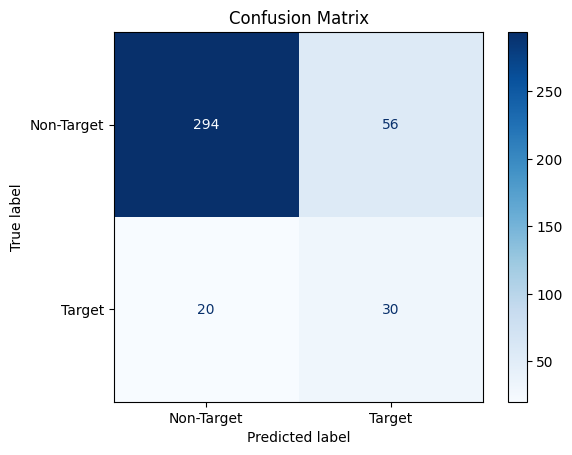

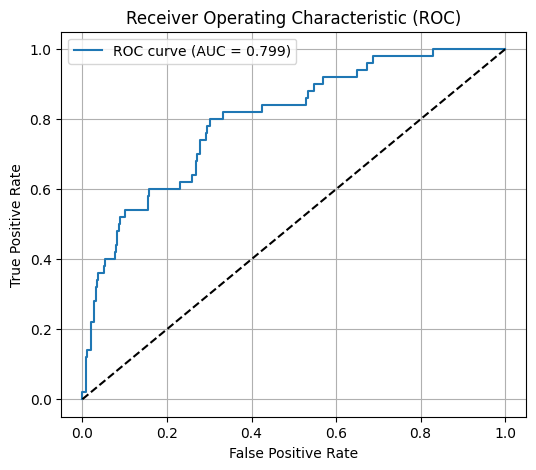


🔥 Top 10 influential features (by weight magnitude):
[ 599  626 1145  625 1146  665  666  670  671 1199]


In [9]:
# --- 6. Feature Extraction and Data Preparation ---
if 'eeg_preprocessed' in locals():
    print("\nExtracting Features...")
    # A. 100–700 ms post-stimulus window
    start_sample = int((200 + 100) * (sampling_rate / 1000)) # 0.3s * 250 Hz = 75
    end_sample = int((200 + 700) * (sampling_rate / 1000))   # 0.9s * 250 Hz = 225

    # Extract the data from this window
    eeg_windowed = eeg_preprocessed[:, start_sample:end_sample, :]  
    print(f"Shape of windowed EEG data: {eeg_windowed.shape}")

    # B. Flatten the data for the model
    num_events = eeg_windowed.shape[2]
    num_features = eeg_windowed.shape[0] * eeg_windowed.shape[1]
    
    # Transpose to (events, channels, samples) then reshape
    features = eeg_windowed.transpose(2, 0, 1).reshape(num_events, num_features)
    print(f"Shape of feature matrix for ML model: {features.shape}")

    # C. Split data into training and testing sets
    # The 'labels' variable is our target (y)
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.25, random_state=42, stratify=labels
    )
    # 'stratify=labels' ensures the train/test sets have the same proportion of targets
    
    print(f"\nTraining set size: {X_train.shape[0]} events")
    print(f"Test set size: {X_test.shape[0]} events")

# --- 7. Train and Evaluate the Classifier ---
if 'X_train' in locals():
    # A. Initialize and train the Logistic Regression model
    model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    print("\nModel training complete!")

    # B. Make predictions on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # C. Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"\nModel Accuracy on Test Set: {accuracy:.2%}")
    print(f"🏁 ROC-AUC Score: {auc:.3f}")

    # Detailed classification metrics
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Target', 'Target']))

    # D. Display the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Target', 'Target'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # E. Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # F. Feature Weight Summary
    coef_abs = np.abs(model.coef_[0])
    top_features = np.argsort(coef_abs)[-10:][::-1]
    print("\n🔥 Top 10 influential features (by weight magnitude):")
    print(top_features)